# Hospital distribution - NN layers - spikes



## Setup imports

In [2]:
import os
import shutil
import json

import matplotlib.pyplot as plt
import numpy as np

from monai.data import partition_dataset, CacheDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.transforms import (
    AddChanneld,
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    ToTensord,
)
from monai.utils import set_determinism
from monai.networks.nets import UNet

import torch
from torch.utils.data import random_split, ConcatDataset
import torch.nn as nn

from tqdm import tqdm

############################################
# Local imports

SOURCE_CODE_PATH = '/homes/yc7620/Documents/medical-vision-textural-bias/source_code/'
import sys
sys.path.append(SOURCE_CODE_PATH)

from filters_and_operators import RandFourierDiskMaskd, WholeTumorTCGA
from utils import show_slice_and_fourier, model_evaluation, ReCompose
from stylization_layers import GibbsNoiseLayer, Gibbs_UNet
#############################################

# set determinism for reproducibility
set_determinism(seed=0)


root_dir = '/vol/bitbucket/yc7620/90_data/53_TCGA_data/'
print('root_dir', root_dir)
print_config()

device = torch.device("cuda:0")

root_dir /vol/bitbucket/yc7620/90_data/53_TCGA_data/
MONAI version: 0.5.dev2113
Numpy version: 1.19.2
Pytorch version: 1.8.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: b3cc668c924b2a7e6b822416f4d920a098c27704

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.2.1
scikit-image version: 0.17.2
Pillow version: 8.1.2
Tensorboard version: 2.5.0
gdown version: 3.12.2
TorchVision version: 0.9.0
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.50.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# Create datasets

In [3]:
# load dict sequences

with open(os.path.join(root_dir, 'train_sequence_by_modality.json'), 'r') as f:
    data_seqs_4mods = json.load(f)
with open(os.path.join(root_dir, 'test_sequence_by_modality.json'), 'r') as f:
    test_seqs_4mods = json.load(f)
with open(os.path.join(root_dir, 'super_test_sequence_by_modality.json'), 'r') as f:
    super_test_seqs_4mods = json.load(f)

# split off training and validation     
_ , val_seq_flair = partition_dataset(data_seqs_4mods["FLAIR"], [0.9, 0.1], shuffle=True, seed=0)
_ , val_seq_t1 = partition_dataset(data_seqs_4mods["T1"], [0.9, 0.1], shuffle=True, seed=0)
_ , val_seq_t1gd = partition_dataset(data_seqs_4mods["T1Gd"], [0.9, 0.1], shuffle=True, seed=0)
_ , val_seq_t2 = partition_dataset(data_seqs_4mods["T2"], [0.9, 0.1], shuffle=True, seed=0)


In [4]:
# preprocessing pipelines

train_transform = ReCompose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys="image"),
        WholeTumorTCGA(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest")
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        RandSpatialCropd(
            keys=["image", "label"], roi_size=[128, 128, 64], random_size=False
        ),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd("image", factors=0.1, prob=0.5),
        RandShiftIntensityd("image", offsets=0.1, prob=0.5),
        ToTensord(keys=["image", "label"]),
    ]
)

val_transform = ReCompose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys="image"),
        WholeTumorTCGA(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
    ]
)

In [5]:
val_ds_flair = CacheDataset(val_seq_flair, val_transform, cache_num=2)
val_ds_t1 = CacheDataset(val_seq_t1, val_transform, cache_num=2)
val_ds_t1gd = CacheDataset(val_seq_t1gd, val_transform, cache_num=2)
val_ds_t2 = CacheDataset(val_seq_t2, val_transform, cache_num=2)

val_ds = ConcatDataset([val_ds_flair, val_ds_t1, val_ds_t1gd, val_ds_t2])
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=4)

test_ds_flair = CacheDataset(test_seqs_4mods["FLAIR"], val_transform, cache_num=2)
test_ds_t1 = CacheDataset(test_seqs_4mods["T1"], val_transform, cache_num=2)
test_ds_t1gd = CacheDataset(test_seqs_4mods["T1Gd"], val_transform, cache_num=2)
test_ds_t2 = CacheDataset(test_seqs_4mods["T2"], val_transform, cache_num=2)

off_dist_ds = ConcatDataset([test_ds_flair, test_ds_t1, test_ds_t1gd, test_ds_t2])
off_dist_loader = DataLoader(off_dist_ds, batch_size=2, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]


In [6]:
super_test_ds_flair = CacheDataset(super_test_seqs_4mods["FLAIR"], val_transform, cache_num=1)
super_test_ds_t1 = CacheDataset(super_test_seqs_4mods["T1"], val_transform, cache_num=1)
super_test_ds_t1gd = CacheDataset(super_test_seqs_4mods["T1Gd"], val_transform, cache_num=1)
super_test_ds_t2 = CacheDataset(super_test_seqs_4mods["T2"], val_transform, cache_num=1)

super_off_dist_ds = ConcatDataset([super_test_ds_flair, super_test_ds_t1, super_test_ds_t1gd, super_test_ds_t2])
super_off_dist_loader = DataLoader(super_off_dist_ds, batch_size=2, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


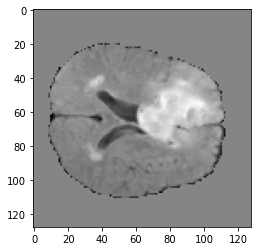

In [4]:
data = val_ds[0]
img = val_ds[0]['image']
truth = val_ds[0]['label']
plt.imshow(data['image'][0,:,:,32], cmap='gray')

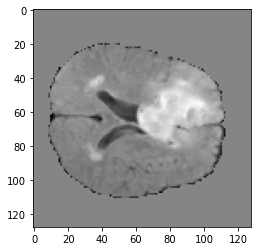

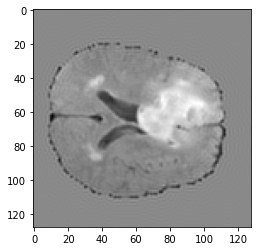

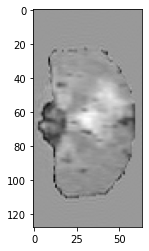

In [10]:
from filters_and_operators import (WholeTumorTCGA, 
                                   RandFourierDiskMaskd,
                                   RandPlaneWaves_ellipsoid,
                                   SaltAndPepper,
                                  )
# gibbs
MASK_RADIUS = 55
# spikes
INTENSITY = 8.
# set sampling ellipsoid
AA, BB, CC = 55.,55.,30.
# sap
PP = 0.00

data = val_ds[0]
plt.imshow(data['image'][0,:,:,32], cmap='gray')
plt.show()

t = Compose([
        RandFourierDiskMaskd(keys='image', r=MASK_RADIUS, inside_off=False, prob=1.),
        RandPlaneWaves_ellipsoid('image',AA,BB,CC, intensity_value=INTENSITY, prob=1.),
        SaltAndPepper(PP)])

data = t(data)
plt.imshow(data['image'][0,:,:,32], cmap='gray')
plt.show()
plt.imshow(data['image'][0,:,64,:], cmap='gray')
plt.show()

# Learning curves

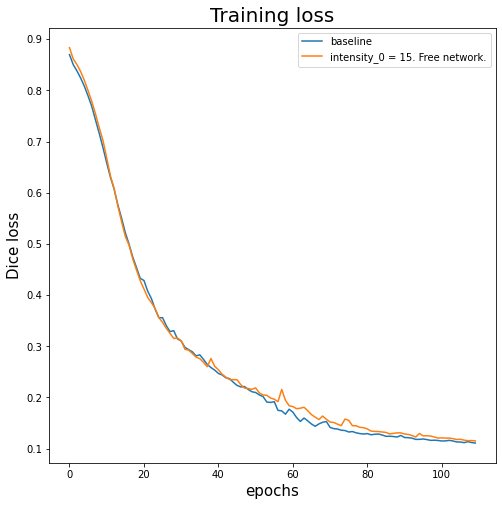

In [7]:
# learning curves 

epoch_loss_baseline = np.loadtxt('/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/baseline_model_sourceDist_4mods_WT/epoch_loss_values_baseline_model_sourceDist_4mods_WT.txt')

epoch_loss_15_freeNet = np.loadtxt('/vol/bitbucket/yc7620/90_data/53_TCGA_data/spikes15_layer_GD_model_sourceDist_4mods_WT/epoch_loss_values_spikes15_layer_GD_model_sourceDist_4mods_WT_2.txt')







plt.figure(figsize=(8,8))
plt.plot(range(len(epoch_loss_baseline)), epoch_loss_baseline, label='baseline')
plt.plot(range(len(epoch_loss_baseline)), epoch_loss_15_freeNet, label='intensity_0 = 15. Free network.')


# plt.plot(range(len(epoch_loss_0p7_freeNet_transfer)), epoch_loss_0p7_freeNet_transfer, label='alpha_0 = 0.7. Free network. Pre-trained ResUnet.')

plt.legend()
plt.title('Training loss', size=20)
plt.xlabel('epochs', size = 15)
plt.ylabel('Dice loss', size = 15)
plt.show()

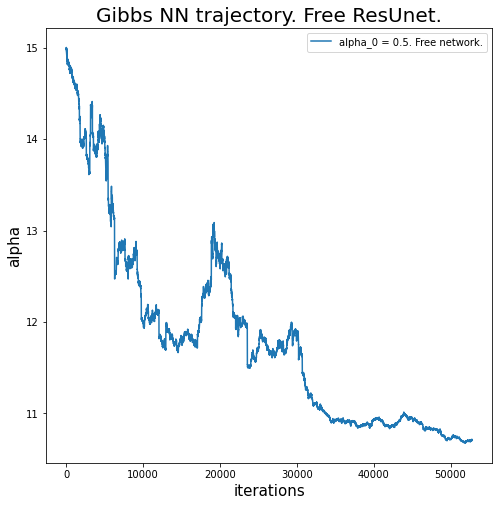

In [9]:
# spikes layer trajectory

gibbs_trajectory_0p5_freeNet = np.loadtxt('/vol/bitbucket/yc7620/90_data/53_TCGA_data/spikes15_layer_GD_model_sourceDist_4mods_WT/spikes_trajectory_spikes15_layer_GD_model_sourceDist_4mods_WT_2.txt')





plt.figure(figsize=(8,8))
plt.plot(range(len(gibbs_trajectory_0p5_freeNet)), gibbs_trajectory_0p5_freeNet, label='alpha_0 = 0.5. Free network.')

# plt.hlines([ .115],0,110, colors='k')
plt.legend()
plt.title('Gibbs NN trajectory. Free ResUnet.', size=20)
plt.xlabel('iterations', size = 15)
plt.ylabel('alpha', size = 15)
# plt.ylim(0,.1)
plt.show()

# Inference

In [7]:
path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/baseline_model_sourceDist_4mods_WT/baseline_model_sourceDist_4mods_WT.pth'
new_baseline_eval = model_evaluation(path, 'baseline model', in_channels=1, out_channels=1)
new_baseline_eval.add_eval('baseline_data', val_loader)
new_baseline_eval.add_eval('val holdout hospital', off_dist_loader)
new_baseline_eval.add_eval('super holdout hospital', super_off_dist_loader)


path = '/vol/bitbucket/yc7620/90_data/53_TCGA_data/spikes15_layer_GD_model_sourceDist_4mods_WT/spikes15_layer_GD_model_sourceDist_4mods_WT_2.pth'
spikes15_freeNet = model_evaluation(path, 'alpha_0 = 0.9. Free ResUnet', in_channels=1, out_channels=1, spikes_unet=True)
spikes15_freeNet.add_eval('baseline_data', val_loader)
spikes15_freeNet.add_eval('holdout hospital', off_dist_loader)
spikes15_freeNet.add_eval('super holdout hospital', super_off_dist_loader)

path = '/vol/bitbucket/yc7620/90_data/53_TCGA_data/spikes13_layer_GD_model_sourceDist_4mods_WT/spikes13_layer_GD_model_sourceDist_4mods_WT.pth'
spikes13_freeNet = model_evaluation(path, 'alpha_0 = 0.9. Free ResUnet', in_channels=1, out_channels=1, spikes_unet=True)
spikes13_freeNet.add_eval('baseline_data', val_loader)
spikes13_freeNet.add_eval('holdout hospital', off_dist_loader)
spikes13_freeNet.add_eval('super holdout hospital', super_off_dist_loader)

path = '/vol/bitbucket/yc7620/90_data/53_TCGA_data/spikes11_layer_GD_model_sourceDist_4mods_WT/spikes11_layer_GD_model_sourceDist_4mods_WT.pth'
spikes11_freeNet = model_evaluation(path, 'alpha_0 = 0.9. Free ResUnet', in_channels=1, out_channels=1, spikes_unet=True)
spikes11_freeNet.add_eval('baseline_data', val_loader)
spikes11_freeNet.add_eval('holdout hospital', off_dist_loader)
spikes11_freeNet.add_eval('super holdout hospital', super_off_dist_loader)

100%|██████████| 24/24 [00:08<00:00,  2.70it/s]


<BarContainer object of 4 artists>

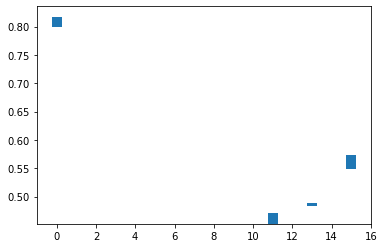

In [19]:
plt.bar(gibbs_values, height=abs(np.array(in_dist_perf)-np.array(out_dist_perf)), 
                     width=.5, bottom = np.array(out_dist_perf), label="Dice scores in and out of hospital distribution")

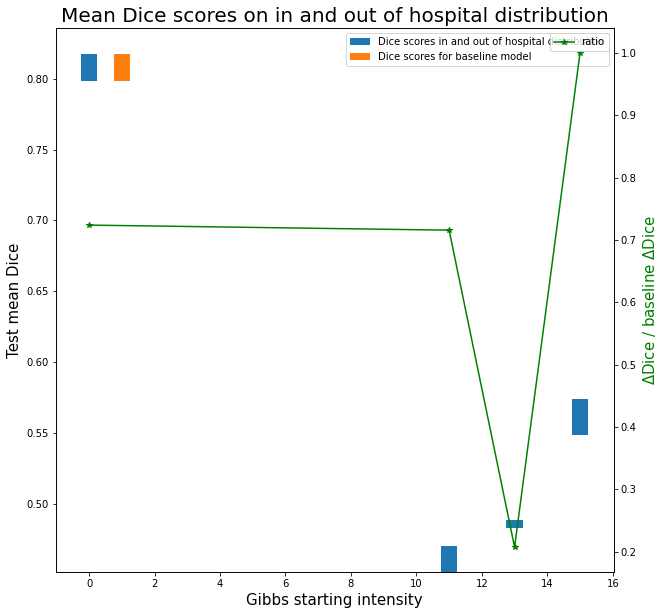

In [21]:
model_evals = [new_baseline_eval,
               spikes11_freeNet,
               spikes13_freeNet,
               spikes15_freeNet]

gibbs_values = [0, 11, 13, 15]

diffs = [abs(m.eval_dict['baseline_data'] - m.eval_dict['super holdout hospital']) for m in model_evals]
normalized_diffs = [x/diffs[-1] for x in diffs]

in_dist_perf = [m.eval_dict['baseline_data'] for m in model_evals]
out_dist_perf = [m.eval_dict['super holdout hospital'] for m in model_evals]

fig, ax1 = plt.subplots(figsize=(10,10))

# plt.ylim(.74,.8)
ax1.set_xlabel('Gibbs starting intensity', size=15)
ax1.set_ylabel('Test mean Dice',size =15)
ax1.bar(gibbs_values, height=abs(np.array(in_dist_perf)-np.array(out_dist_perf)), 
                     width=.5, bottom = np.array(out_dist_perf), label="Dice scores in and out of hospital distribution")
ax1.bar(1, height=abs(np.array(in_dist_perf[0])-np.array(out_dist_perf[0])), 
                     width=.5, bottom = np.array(out_dist_perf[0]), label="Dice scores for baseline model")
plt.legend()

ax2 = ax1.twinx()
ax2.set_ylabel(r'$\Delta$Dice / baseline $\Delta$Dice', color='green', size=15)
ax2.plot(gibbs_values,normalized_diffs, '*-',c='green', label='ratio')
plt.legend()
plt.title('Mean Dice scores on in and out of hospital distribution', size=20)
plt.show()

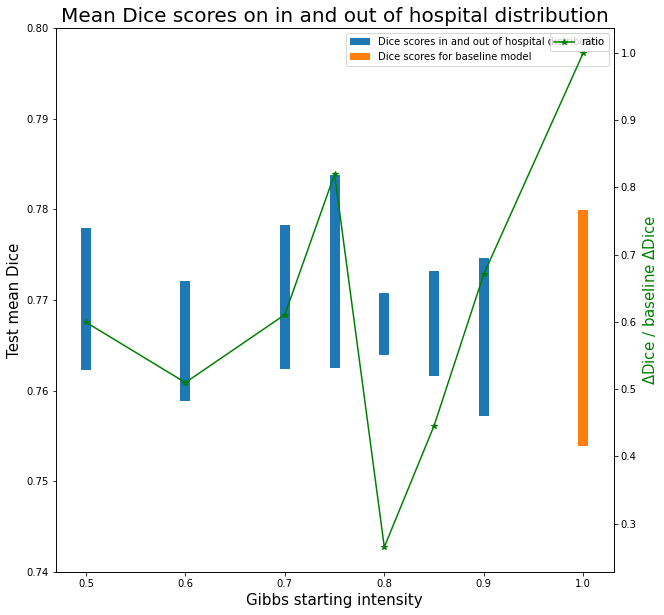

In [51]:
model_evals = [
               gibbs0p5_freeNet,
               gibbs0p6_freeNet,
               gibbs0p7_freeNet,
               gibbs0p75_freeNet,
               gibbs0p8_freeNet,
               gibbs0p85_freeNet,
               gibbs0p9_freeNet,
               baseline_eval]

gibbs_values = [0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 1]

diffs = [abs(m.eval_dict['baseline_data'] - m.eval_dict['holdout hospital']) for m in model_evals]
normalized_diffs = [x/diffs[-1] for x in diffs]

in_dist_perf = [m.eval_dict['baseline_data'] for m in model_evals]
out_dist_perf = [m.eval_dict['holdout hospital'] for m in model_evals]

fig, ax1 = plt.subplots(figsize=(10,10))

plt.ylim(.74,.8)
ax1.set_xlabel('Gibbs starting intensity', size=15)
ax1.set_ylabel('Test mean Dice',size =15)
ax1.bar(gibbs_values, height=abs(np.array(in_dist_perf)-np.array(out_dist_perf)), 
                     width=.01, bottom = np.array(out_dist_perf), label="Dice scores in and out of hospital distribution")
ax1.bar(1, height=abs(np.array(in_dist_perf[-1])-np.array(out_dist_perf[-1])), 
                     width=.01, bottom = np.array(out_dist_perf[-1]), label="Dice scores for baseline model")
plt.legend()

ax2 = ax1.twinx()
ax2.set_ylabel(r'$\Delta$Dice / baseline $\Delta$Dice', color='green', size=15)
ax2.plot(gibbs_values,normalized_diffs, '*-',c='green', label='ratio')
plt.legend()
plt.title('Mean Dice scores on in and out of hospital distribution', size=20)
plt.show()

## Faster learning rates

# Inference

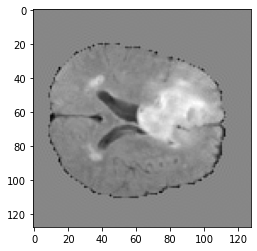

In [39]:
g = GibbsNoiseLayer(.7).to(device)
img_g = g(img.cuda()).detach().cpu()
plt.imshow(img_g[0,:,:,32], cmap='gray')

Let's segment img_g

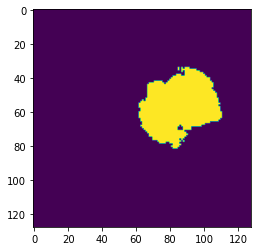

In [40]:
gunet = Gibbs_UNet().to(device)
gunet.ResUnet.load_state_dict(torch.load('/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/baseline_model_sourceDist_4mods_WT/baseline_model_sourceDist_4mods_WT.pth'))

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold_values=True)])
dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_loss = DiceLoss(to_onehot_y=False, sigmoid=False, squared_pred=True)

zero_seg = post_trans(gunet.ResUnet(img_g.unsqueeze(0).cuda()))
plt.imshow(zero_seg[0,0,:,:,32].detach().cpu())

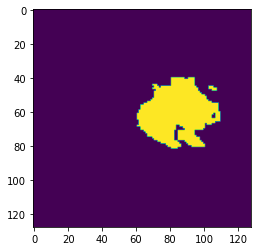

In [51]:
plt.imshow(truth[0,:,:,32])

In [41]:
dice_loss(zero_seg[0], truth.to(device))

tensor(0.1220, device='cuda:0')

In [42]:
(0.1224-0.1220)/(.8-.7)

0.003999999999999972

In [15]:
class Gibbs_UNet(nn.Module):
    """ResUnet with Gibbs layer"""

    def __init__(self, alpha=None):
        super().__init__()

        self.gibbs = GibbsNoiseLayer(.5)

        self.ResUnet = UNet(
        dimensions=3,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    )

    def forward(self,img):
        img = self.gibbs(img)
        img = self.ResUnet(img)
        return img

device = torch.device("cuda:0")

model = Gibbs_UNet().to(device)

model.load_state_dict(torch.load('/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/gibbs0.7_layer_model_sourceDist_4mods_WT/gibbs0.7_layer_model_sourceDist_4mods_WT.pth'))

<All keys matched successfully>

In [20]:
model.gibbs.alpha

Parameter containing:
tensor(0.2167, device='cuda:0', requires_grad=True)

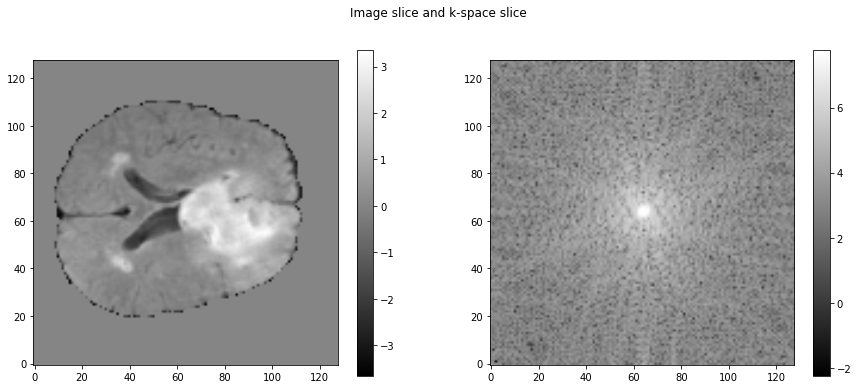

NameError: name 'model' is not defined

In [25]:
fixed_img = val_ds[0]['image']
truth = val_ds[0]['label']
# plain image
show_slice_and_fourier(fixed_img[0,:,:,32])
# image after gibbs layer
img_gibbs = model.gibbs(fixed_img.to(device)).detach().cpu()
show_slice_and_fourier(img_gibbs[0,:,:,32])

### Model comparisons - Gibbs

In [7]:
path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/baseline_model_sourceDist_4mods_WT/baseline_model_sourceDist_4mods_WT.pth'
baseline_eval = model_evaluation(path, 'baseline model', in_channels=1, out_channels=1)
baseline_eval.add_eval('baseline_data', val_loader)
baseline_eval.add_eval('holdout hospital', off_dist_loader)

path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/gibbs0.7_layer_model_sourceDist_4mods_WT/gibbs0.7_layer_model_sourceDist_4mods_WT.pth'
gibbs_layer_0p7 = model_evaluation(path, 'gibbs0.7', gibbs_unet=True)
gibbs_layer_0p7.add_eval('in_distribution', val_loader)
gibbs_layer_0p7.add_eval('out_distribution', off_dist_loader)


100%|██████████| 44/44 [00:15<00:00,  2.87it/s]


In [9]:
baseline_eval.eval_dict

defaultdict(list,
            {'baseline_data': 0.7799423107734094,
             'holdout hospital': 0.7539122016592459})

In [8]:
gibbs_layer_0p7.eval_dict

defaultdict(list,
            {'in_distribution': 0.7284428568986746,
             'out_distribution': 0.6807635175910863})

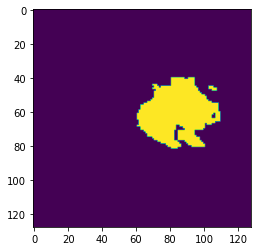

In [27]:
plt.imshow(truth[0,:,:,32])

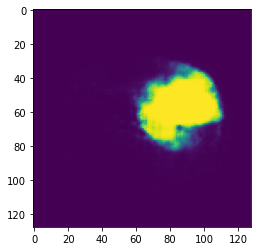

In [28]:
baseline_seg = baseline_eval.model(fixed_img.unsqueeze(0).to(device))
plt.imshow(torch.sigmoid(baseline_seg[0,0,:,:,32].detach().cpu()))
plt.show()

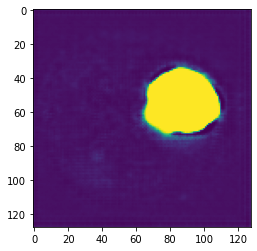

supressing -Inf


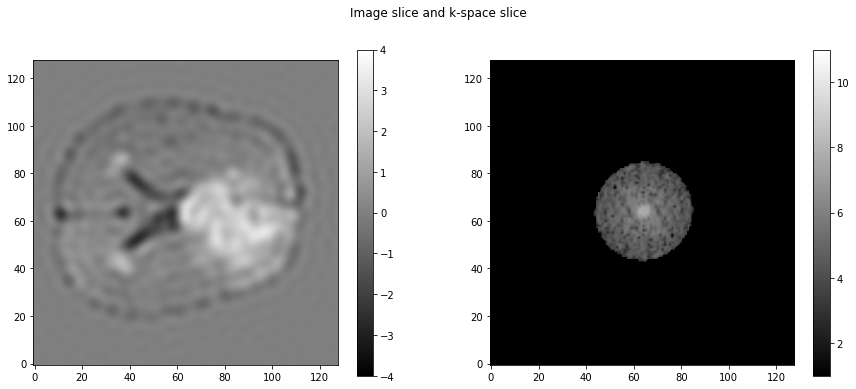

In [40]:
gibbs_unet_seg = gibbs_layer_0p7.model(fixed_img.unsqueeze(0).to(device))
plt.imshow(torch.sigmoid(gibbs_unet_seg[0,0,:,:,32].detach().cpu()))
plt.show()

gibbs_unet_img = gibbs_layer_0p7.model.gibbs(fixed_img.unsqueeze(0).to(device))
show_slice_and_fourier(gibbs_unet_img.detach().cpu()[0,0,:,:,32],0,8, 6, 10)

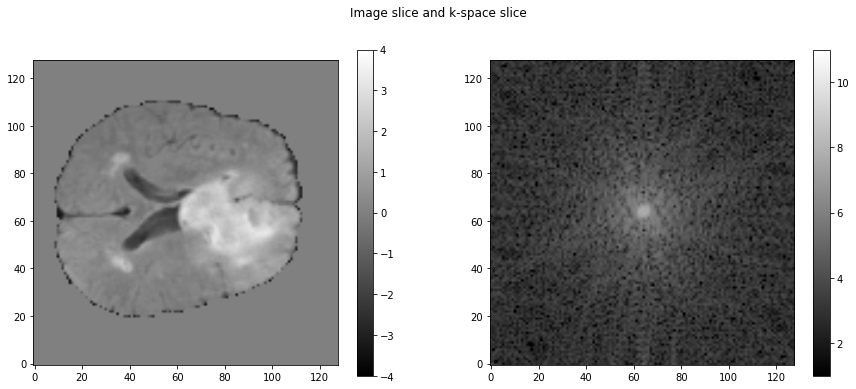

In [41]:
show_slice_and_fourier(fixed_img[0,:,:,32],0,8, 6, 10)

In [42]:
fixed_img.size()

torch.Size([1, 128, 128, 64])